In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=15,
       titlepad=11,
      )

from sklearn.feature_selection import mutual_info_regression

In [2]:
autos = pd.read_csv("Datasets/autos.csv")

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    object 
 2   fuel_type          193 non-null    object 
 3   aspiration         193 non-null    object 
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    object 
 6   drive_wheels       193 non-null    object 
 7   engine_location    193 non-null    object 
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    object 
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

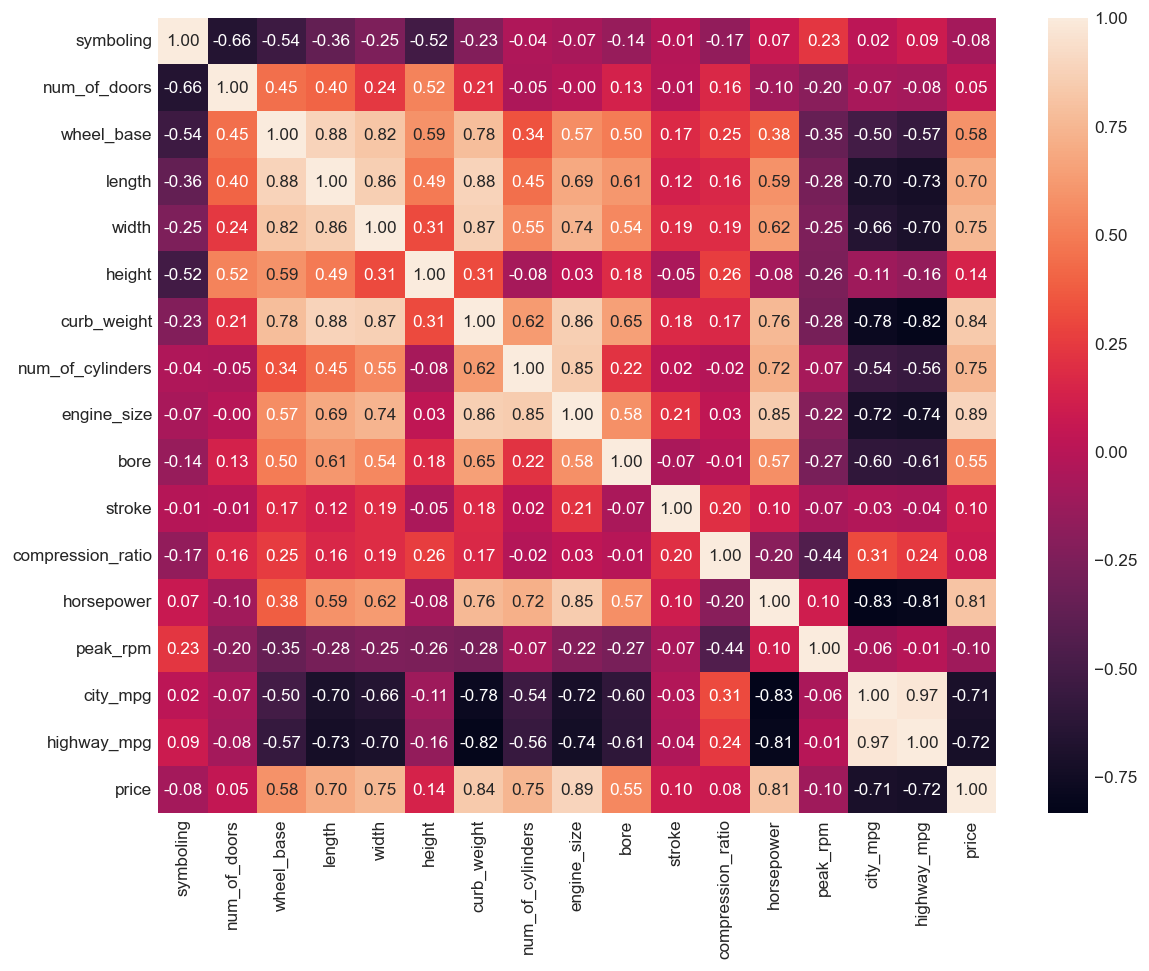

In [4]:
plt.figure(figsize=(10,8),dpi = 123)
sns.heatmap(autos.corr(),
           annot=True,
            fmt='.2f'
           )
plt.show()

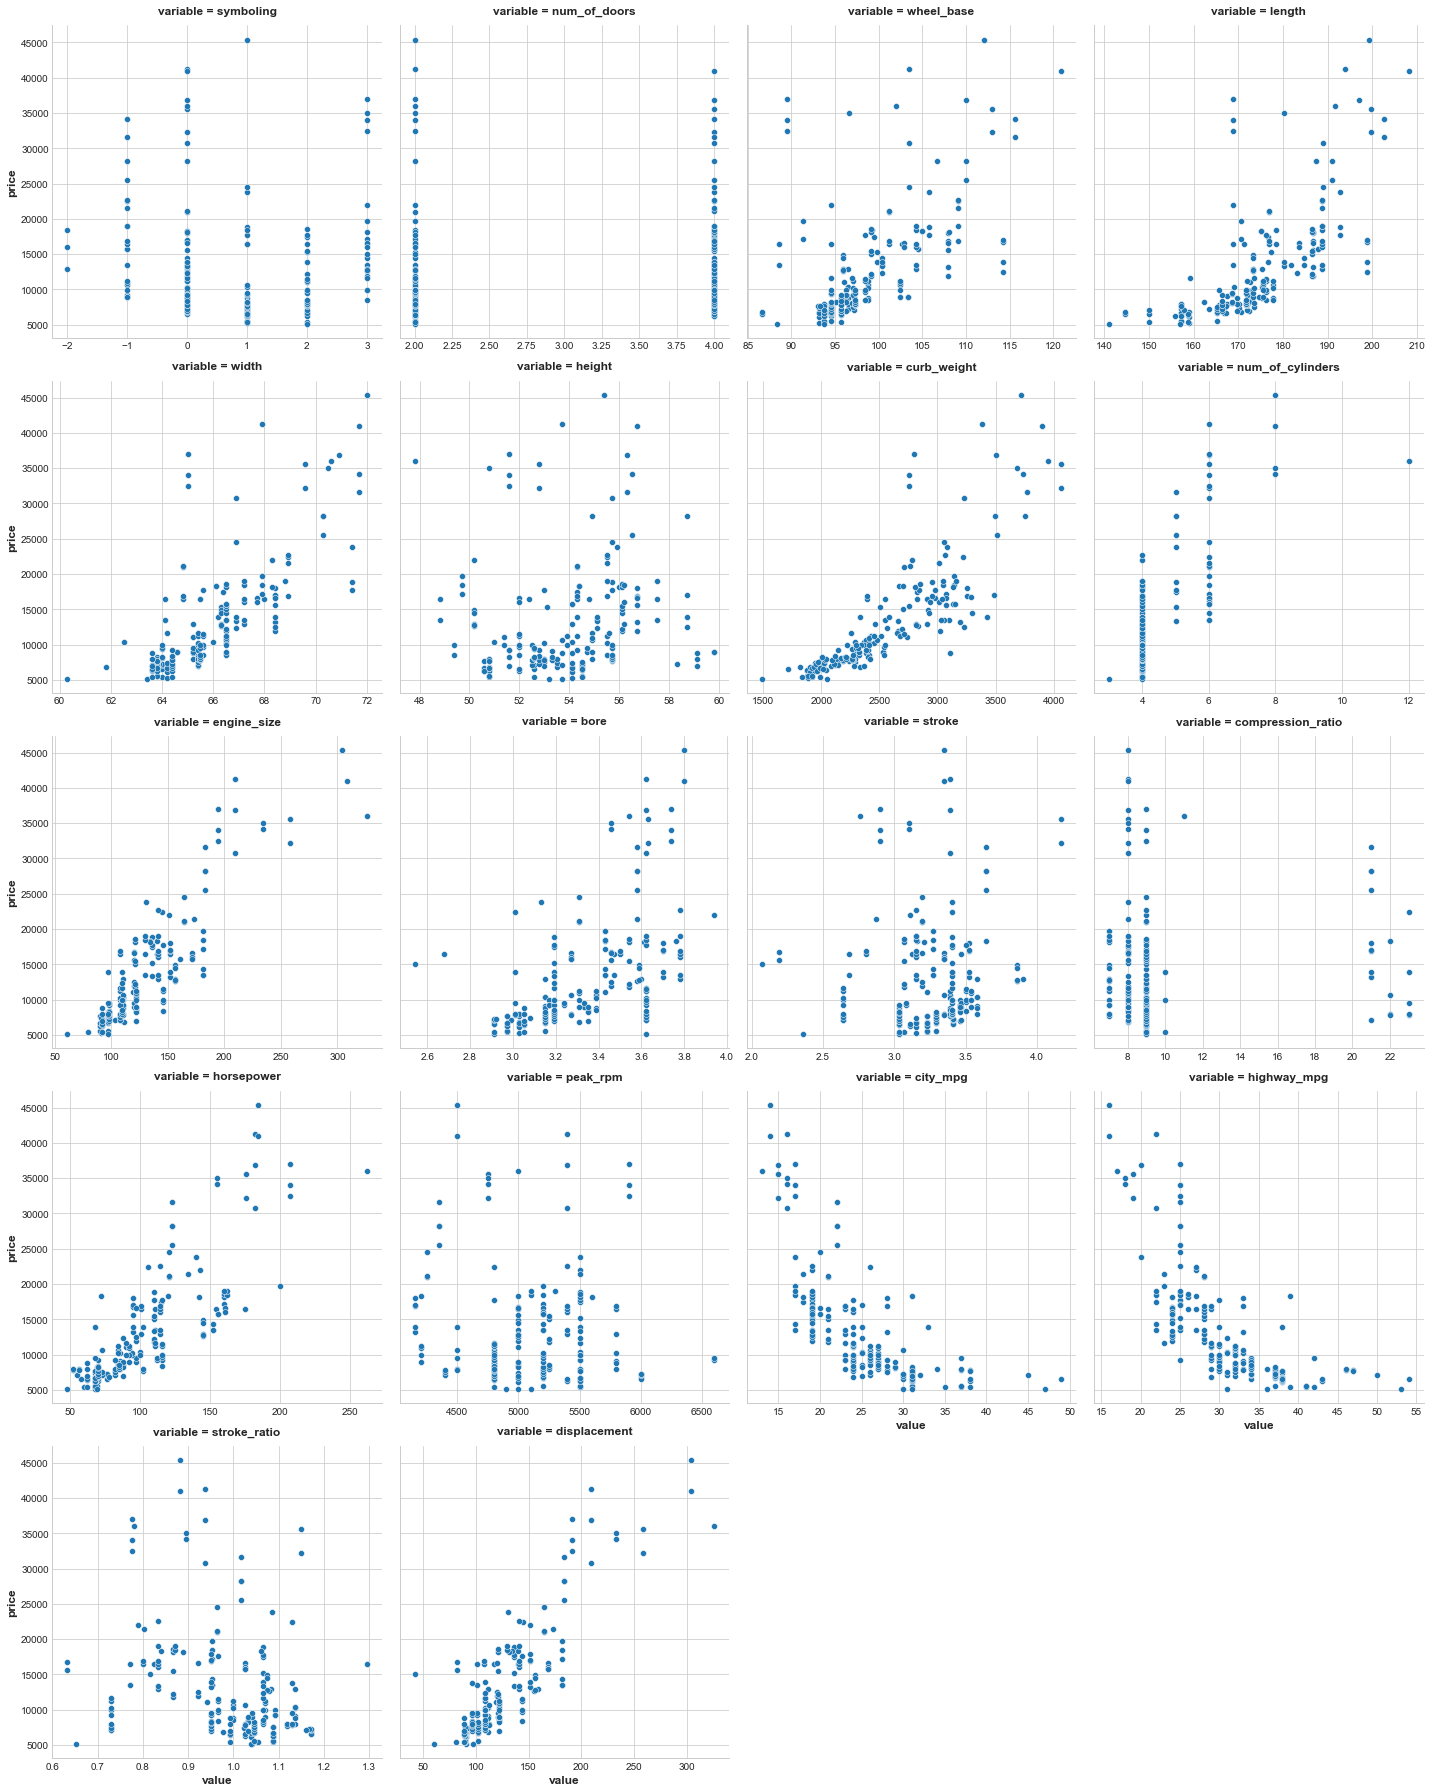

In [13]:
features = ['engine_size', 'curb_weight','horsepower', 'num_of_cylinders','width','length','highway_mpg','city_mpg']
can = [col for col in autos.columns if autos[col].dtypes=='int64' or autos[col].dtypes=='float64' ]
can

#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="price", 
            col="variable",
            col_wrap=4,
            data=autos.melt(id_vars="price", value_vars=can),
            facet_kws=dict(sharex=False),
)
plt.show()

In [6]:
cat = [col for col in autos.columns if autos[col].dtypes=='object']
cat

['make',
 'fuel_type',
 'aspiration',
 'body_style',
 'drive_wheels',
 'engine_location',
 'engine_type',
 'fuel_system']

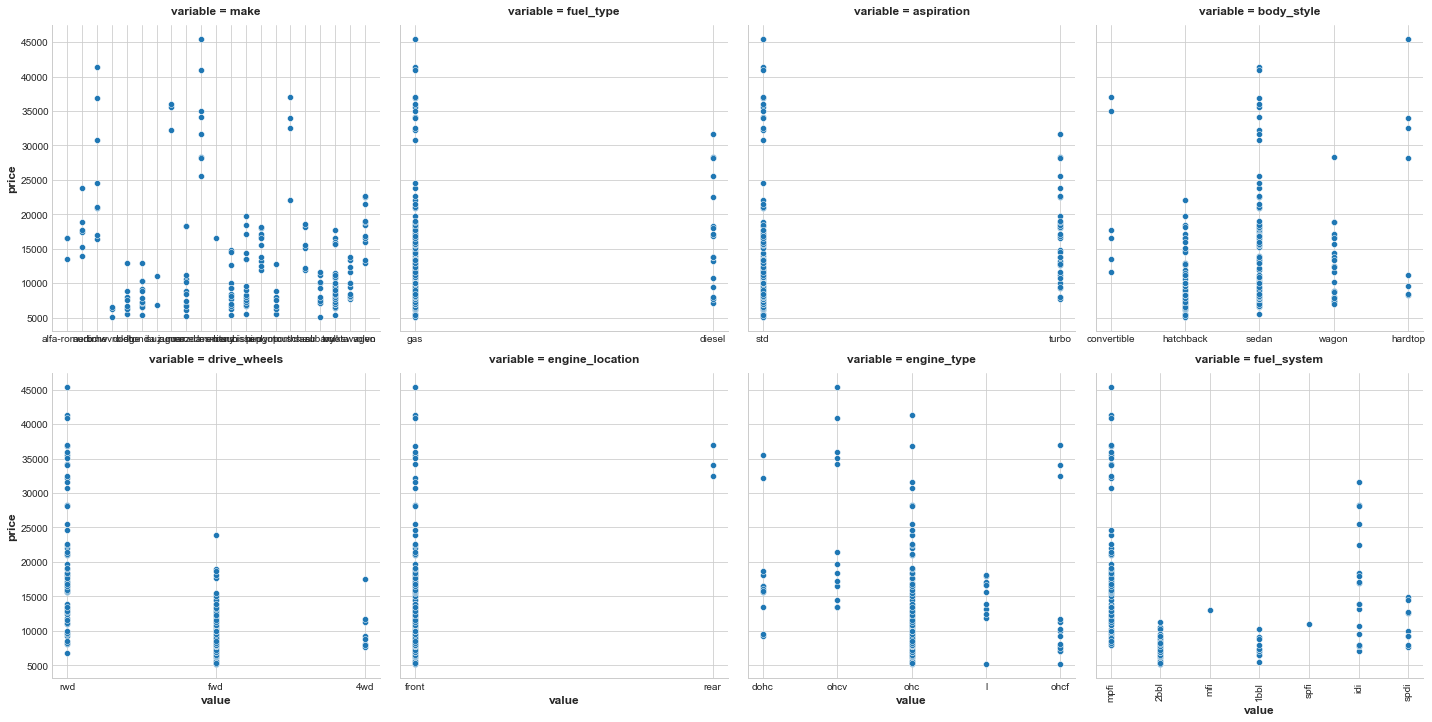

In [7]:
#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="price", 
            col="variable",
            col_wrap=4,
            data=autos.melt(id_vars="price", value_vars=cat),
            facet_kws=dict(sharex=False),
)

plt.xticks(rotation = 90)                                             
plt.show()

### Mutual Information

In [19]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
        
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

In [29]:
X = autos.copy()
y = X.pop('price')

mi_scores = make_mi_scores(X, y)
mi_scores[::4]

curb_weight          1.525199
city_mpg             0.857743
wheel_base           0.590936
peak_rpm             0.453113
drive_wheels         0.332726
compression_ratio    0.133637
engine_location      0.035905
Name: MI Scores, dtype: float64

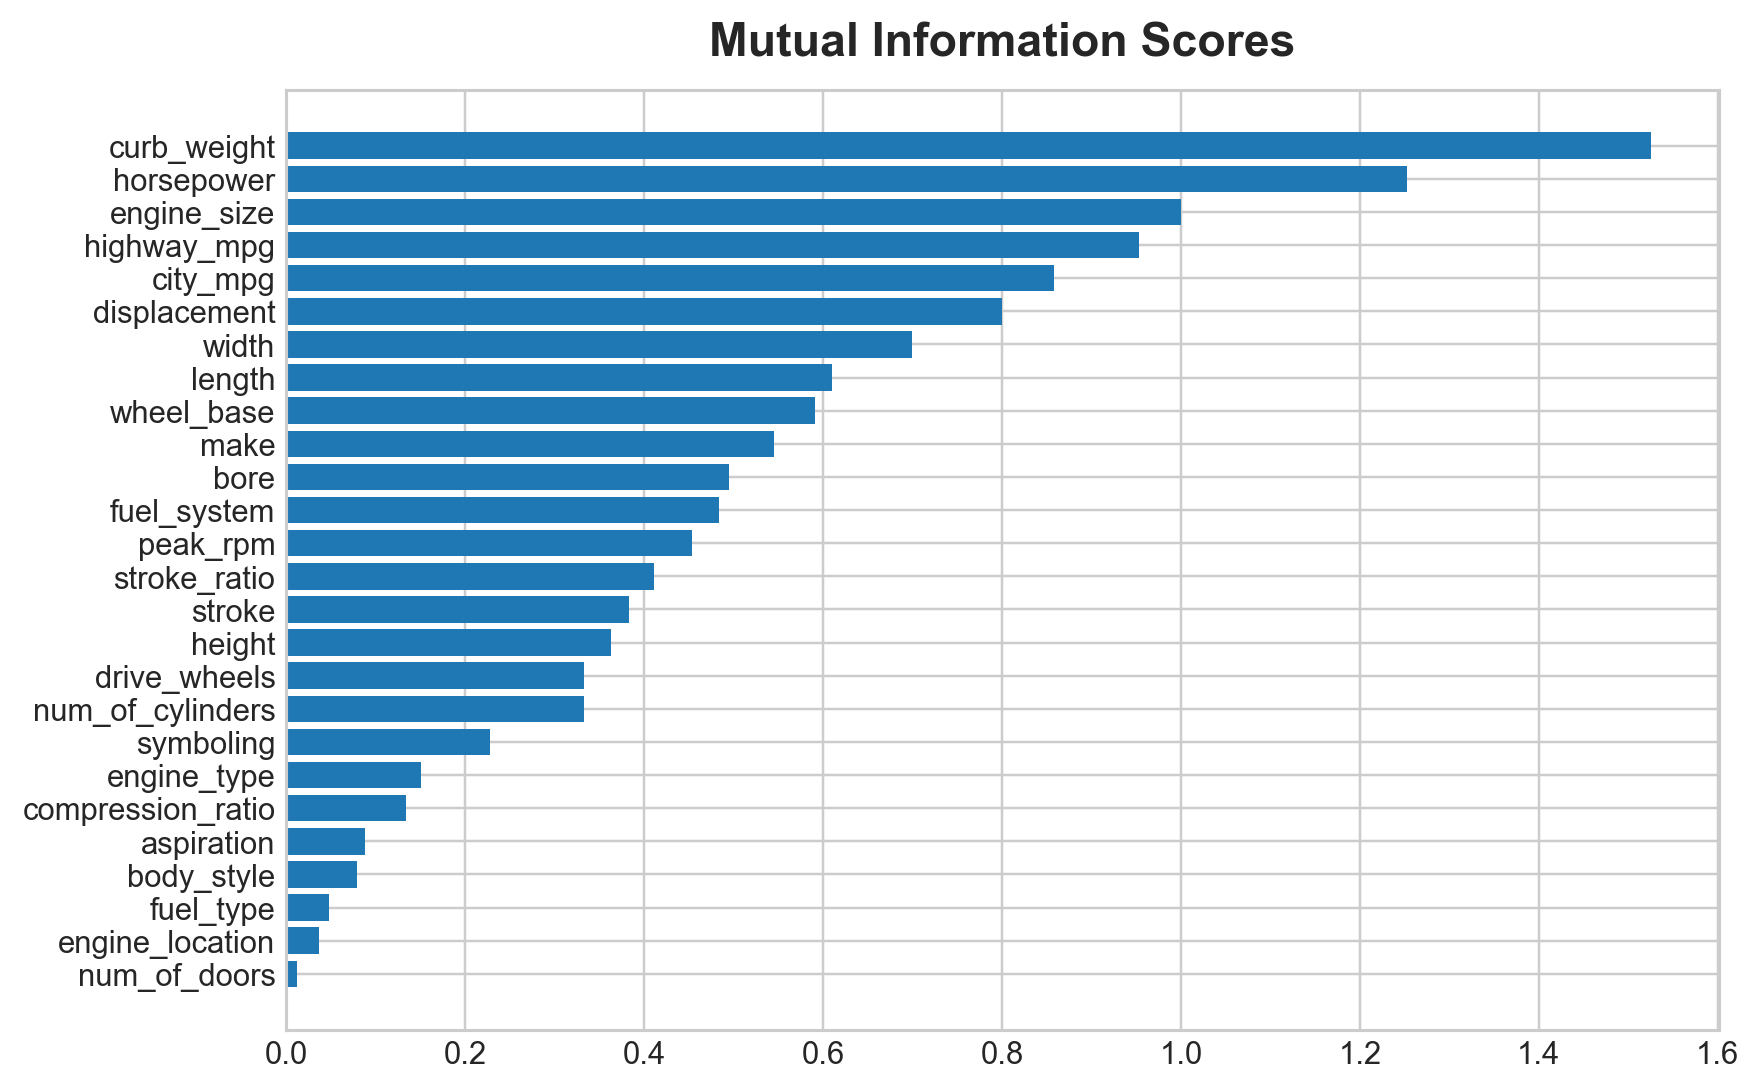

In [30]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=223, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [8]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


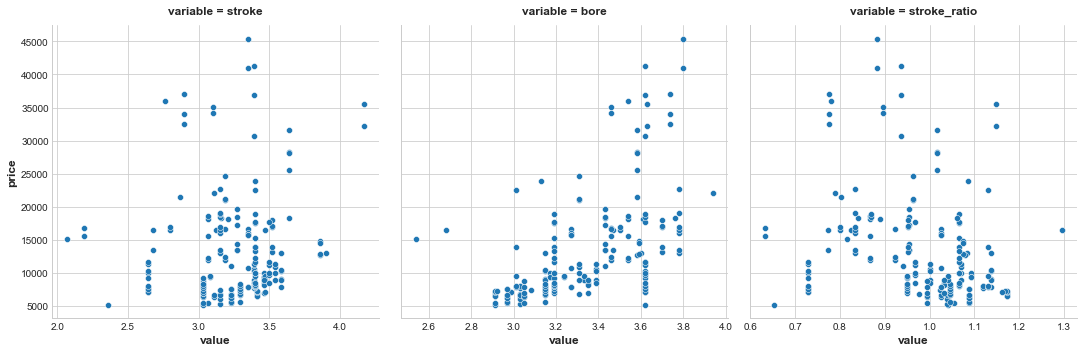

In [17]:
features = ["stroke", "bore", "stroke_ratio"]

#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="price", 
            col="variable",
            col_wrap=4,
            data=autos.melt(id_vars="price", value_vars=features),
            facet_kws=dict(sharex=False),
)
plt.show()

In [10]:
autos["displacement"] = (np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders)

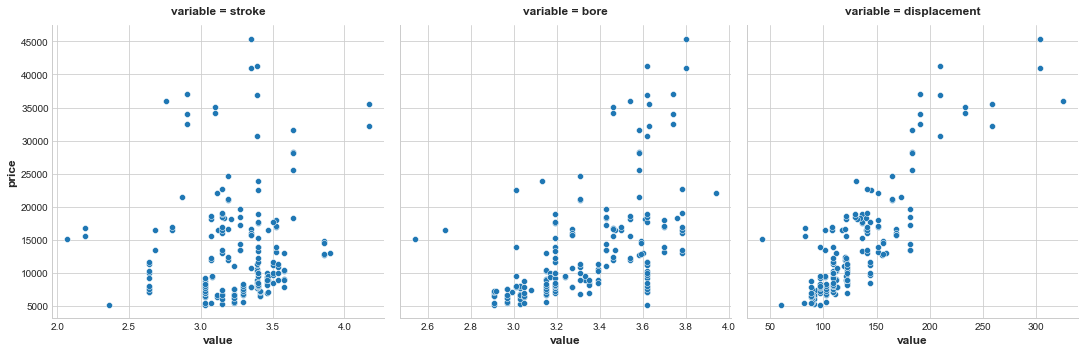

In [18]:
features = ["stroke", "bore", "displacement"]

#Figure-level interface for drawing relational plots onto a FacetGrid.
sns.relplot(x="value", 
            y="price", 
            col="variable",
            col_wrap=4,
            data=autos.melt(id_vars="price", value_vars=features),
            facet_kws=dict(sharex=False),
)
plt.show()

# Building-Up and Breaking-Down Features¶

Join simple features into a composed feature if you had reason to believe there was some interaction in the combination:

In [32]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].sample(5)

,make,body_style,make_and_style
123,saab,sedan,saab_sedan
114,plymouth,wagon,plymouth_wagon
105,peugot,wagon,peugot_wagon
82,nissan,sedan,nissan_sedan
118,porsche,hardtop,porsche_hardtop


# Tips on Creating Features
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
* Linear models learn sums and differences naturally, but can't learn anything more complex.
* Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
* Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.